In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Part II: vWS Development

*This notebooks presents the mathematical details, plots, and descriptions involved in developing the virtual Win-Shares maetric vWS.*

## Summary: 

After carrying out and implementing everything below to build vWS, I achieve a significant improvement over the tratitional WS metric. 

**Correlation between new vWS and Team Quality:** 0.8748

**Correlation between traditional WS and Team Quality:** 0.7757

This gives confidence in proceeding to build the player value app based on vWS. 

## Merging necessary data frame to perform analysis. 

Read in scraped data from College Basketball Reference (player stats) and Kenpom.com (team stats) and merge together.

In [3]:
cbb=pd.read_csv('cbb_full_data.csv')
del cbb['Unnamed: 0']

 Now merge the player stats data with team outcome data from Ken Pomeroy (https://kenpom.com/). Since school naming conventions vary between sites, use the `cbb_kenpom_team_names_lookup_table` file to facilitate merges.

In [4]:
kenpom=pd.read_csv('KenPomDataSince2004.csv')

First change annoying date structure that somehow got in there -- 20-Dec should be a W-L of 12-20. Probably happened from passing through Excel with the kenpom data.

In [5]:
def fixwl(row):
    molist=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    modict={"Jan":'1',"Feb":'2',"Mar":'3',"Apr":'4',"May":'5',"Jun":'6',"Jul":'7',"Aug":'8',"Sep":'9',"Oct":'10',"Nov":'11',"Dec":'12'}
    if row['W-L'].split("-")[1] in molist:
        x=row['W-L'].split("-")[1]
        y=row['W-L'].split("-")[0]
        return modict[x]+"-"+y
    else:
        return row['W-L']

In [6]:
kenpom["W-L"]=kenpom.apply(fixwl,axis=1)

Split `W-L` into separate `W` and `L` columns.

In [7]:
def wins(row):
    return int(row['W-L'].split("-")[0])
def losses(row):
    return int(row['W-L'].split("-")[1])

In [8]:
kenpom['Wins']=kenpom.apply(wins,axis=1)
kenpom['Losses']=kenpom.apply(losses,axis=1)

Import team name lookup table

In [9]:
tm_name_lookup=pd.read_csv('cbb_kenpom_team_names_lookup_table.csv')

Merge together player stats and team info:

In [10]:
kenpom=kenpom.merge(tm_name_lookup,how='left',left_on='TeamName',right_on='KP Team Name')

In [11]:
kp11on=kenpom[kenpom['Season']>=2011].reset_index(drop=1)

In [12]:
kp11on.to_csv('kenpom_2011_on',index=0)

In [13]:
kp11on_lim=kp11on[['Season', 'Tempo', 'RankTempo', 'AdjTempo', 'RankAdjTempo',
       'OE', 'RankOE', 'AdjOE', 'RankAdjOE', 'DE', 'RankDE', 'AdjDE',
       'RankAdjDE', 'AdjEM', 'RankAdjEM', 'Rk', 'W-L', 'AdjO', 'AdjD',
       'AdjOppOE', 'AdjOppDE', 'Wins', 'Losses', 'CBB Team Link']]

In [14]:
cbb_kp=cbb.merge(kp11on_lim,how='left',left_on=['Season','Team'],right_on=['Season','CBB Team Link'])

**Check for missing data after merge** -- Looks good.

In [15]:
cbb_kp.loc[cbb_kp['AdjEM'].isna()][['Team','Season']]['Team'].unique()

array([], dtype=object)

In [16]:
cbb_kp.loc[cbb_kp['CBB Team Link'].isna()]['Team'].unique()

array([], dtype=object)

Add individual player possession column IndOffPoss. This is required later in the WS formula. 

For each player, use 
$$
ORtg=100*(Points Produced)/(IndOffPoss)
$$
to estimate IndOffPoss.

Also, we fix USG% for cases with extreme outlier values due to very low minutes played.

In [17]:
def indposs(row):
    if ((row['PProd']==0)&(row['MP']>0)):
        return 0
    elif ((row['ORtg']>0)&(row['MP']>0)):
        return row['PProd']*100/row['ORtg']
    else:
        return np.nan

def repair_usg(row):
    if (row['USG%']>=40)&(row['MP']<=100):
        return 17.15
    else:
        return(row['USG%'])

In [18]:
cbb_kp['IndOffPoss']=cbb_kp.apply(indposs,axis=1)
cbb_kp['USG%']=cbb_kp.apply(repair_usg,axis=1)

## Analyzing and addressing the relationship between Efficiency and Usage

WS is calculated in two parts as OWS (Offensive Win Shares) + DWS (Defensive Win Shares). 

WS formula: https://www.sports-reference.com/cbb/about/ws.html

I focus on OWS and make only one small adjustment to DWS later. The main ingredient in OWS is Offensive Rating (ORtg = player points per 100 individual possessions). That's the main focus of this analysis.

**Here's the main issue we're trying to deal with.**

Offensive Rating (ORtg) increases slightly as Usage% (USG%: %of team possessions used by a player) increases, but variance is much larger at lower values of USG%. This means that the most and least efficient players *always* occur at lower values of USG%. Especially in college basketball, where there is a premium on players who can create their own shots/offense and tend to have higher usage, this fails to properly reflect value. 

The cone-shape in the scatterplot below shows this relationship clearly. Lower USG% has higher variance; higher USG% has lower variance.

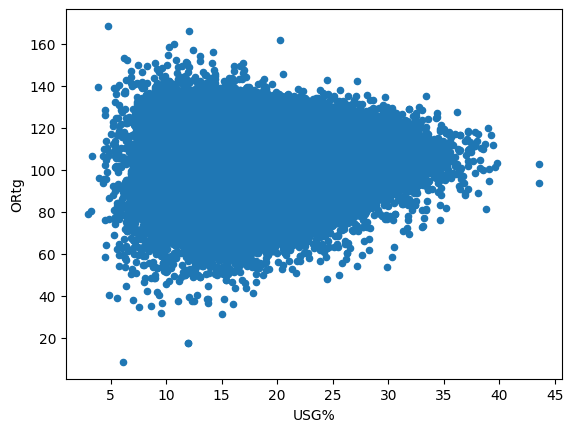

In [19]:
cbb_kp[cbb_kp['MP']>=100].plot.scatter(x='USG%',y='ORtg')
plt.show()

At the same time there *are* lower USG% players who are highly efficient and have high value. Ultimately we want to properly reflect the value of higher USG% players while still allowing some high efficiency players to appear as high value at lower USG%.

In other sports like baseball, Bayesian methods have been used to make comparisons between players with widely varying numbers of at-bats, where a similar phenomenon exists. (See, for example: http://varianceexplained.org/r/simulation-bayes-baseball/)

In that case, using a beta-distribution fit to the data they can effectively pull low at-bat players toward the mean while, for higher at-bat players, the actual values of hits and at-bats dominate the beta parameters (so the high at-bat players are "shrunk" less). 

A similar apprach here (after lots of reading and experimenting) seems to be:
1. Fitting a regression line $\hat{ORtg} = b_0+b_1\cdot(USG\%)$.
2. Shrinking each point towards the regression line by taking a weighted average of the point's actual $ORtg$-value and the corresponding value of $\hat{ORtg}$ at the same $USG\%$. The weights $w_i$ are $\frac{\tau^2}{\tau^2+\sigma_i^2}$, where $\tau^2$ is an empirical estimate of the variance around the regression line, and $\sigma_i^2$ is proportional to $1/USG\%_i$ (the reciprocal of the USG% at point $i$).
3. Using $w_iORtg_i+(1-w_i)\hat{ORtg}_i$, the true value of $ORtg_i$ should dominate as USG% increases since $w_i$ will be close to 1, while for lower USG% players $w_i$ is is closer to 0 and $\hat{ORtg}$ is more influential.

Unfortunately, I could not get this to work well with my data. It reversed the shape of the cone completely, but shrunk lower USG% players towards the regression line too much. Lower USG% players had very little ability to "stand-out". Other attempts to moderate the shrinkage in related ways similarly failed to give reasonable results.

## Solution

**Adjust Offensive Rating based on Usage as follows:**

Building on the ideas above but taking a different (simpler?) approach:

1. Fit the regression line giving Offensive Rating as a function of Usage %. So at USG% $u$,  $\hat{ORtg_{u}} = b_0+b_1\cdot(u)$
3. Compute the residuals. For point $i$, at USG% $u$, $r_{i,u}=ORtg_{i,u}-\hat{ORtg_{u}}$
4. Fit another regression to the squared residuals as a function of USG%. At USG% $u$ we have $\hat{r}^2_{i,u} = c_0 + c_1\cdot(u)$.

Let $s_u$ be the estimated standard deviation (using the regression in 3) of ORtg at the USG% value $u$.

Let $s_{\overline{u}}$ be the estimated standard deviation of ORtg at the average value $\overline{u}$ of $USG\%$.

Note: From the data the average value of USG% is 19.

4. For each observation, calculate the $z$-score of its ORtg based on estimated standard deviation at the observation's USG% value $u$. 
$$
z_{i,u}= \frac{ORtg_{i,u}-\hat{ORtg_u}}{s_u}
$$

So $z_{i,u}$ is the number of $s_u$-standard deviations above (below) the regression line observation $i$ is at USG% $u$. 

5. For observation $i$ with USG% $u$, replace $ORtg_{i,u}$ with $\hat{ORtg_u}+z_{i,u}\cdot s_{\overline{u}}$.

So, if a player with USG% $u$ has an ORtg that is 2 $s_u$-standard deviations above (below) the predicted value on the regression line, we would move him to be 2 $s_{\overline{u}}$-standard deviations above (below) the value on the line.

Since high usage players have smaller than average $s_u$-standard deviations ($s_u<s_{\overline{u}}$), this has the effect of "stretching" them further from the line. For lower usage players, $s_u>s_{\overline{u}}$ so this has the effect of shrinking them towards the line. The effect is to create a relationship between adjusted ORtg and USG that looks more reasonable (see below) by creating more constant variance around the regression line.

6. The scatterplot (below) looks better but *still* seems to overvalue low USG%. A lot less than before though. We can make one more adjustment by penalizing a player further for every percentage point below average USG%.

7. Multiply by a strength of schedule factor (Team Points per Possession / Opponents Points per Possession) to get adjusted Offensive Rating: adjORtg.

8. Use adjORtg in place of ORtg in the WS formula. See https://www.sports-reference.com/cbb/about/ws.html for an overview of the  formula. Win Shares is computed in two parts: Offensive (OWS) and Defensive (DWS) Win shares. I also added a strength of schedule weight to defensive win shares but otherwise left it alone. 

This is all implemented here with some minor adjustments to ignore low-minute or otherwise extreme outliers.

## Implementation

In [20]:
#import for regressions
import statsmodels.formula.api as sm

First build the ORtg ~ USG% model.

In [21]:
ORtg_USG_Mod=sm.ols(formula="ORtg ~ Q('USG%')", data=cbb_kp[cbb_kp['MP']>=100]).fit()

Compute residuals.

In [22]:
cbb_kp['res'] = cbb_kp['ORtg']-ORtg_USG_Mod.predict(cbb_kp['USG%'])

Truncate extreme residuals so they don't skew the models:

In [23]:
def trunc_res(row):
    if (row['res']>40):
        return 40
    elif (row['res']<=(-40)):
        return -40
    else:
        return(row['res'])

In [24]:
cbb_kp['trunc_res']=cbb_kp.apply(trunc_res,axis=1)

Compute squared residuals after truncating.

In [25]:
cbb_kp['trunc_res2']=cbb_kp['trunc_res']**2

Build squared residual model. Exclude more extreme values in model build: 

In [26]:
res2_mod=sm.ols(formula = "trunc_res2 ~ Q('USG%')", data=cbb_kp[(cbb_kp['MP']>=100)&(cbb_kp['trunc_res2']<1600)]).fit()

Define the $z$-score for each point using the appropriate value of standard deviation based on the point's USG% value:

In [27]:
def sd2_adj(row):
    sd = np.sqrt(max((res2_mod.params['Intercept']+res2_mod.params["Q('USG%')"]*row['USG%']),(res2_mod.params['Intercept']+res2_mod.params["Q('USG%')"]*35)))
    yhat = ORtg_USG_Mod.params['Intercept']+ORtg_USG_Mod.params["Q('USG%')"]*row['USG%']
    return (row['ORtg']-yhat)/sd

Create a column giving the $z$-score at $u$ for each observation.

In [28]:
cbb_kp['sd2']=cbb_kp.apply(sd2_adj,axis=1)

Find the standard deviation at the average usage value of 19.

In [29]:
sd2_avg=np.sqrt(res2_mod.params['Intercept']+res2_mod.params["Q('USG%')"]*19)

Now adjust ORtg as defined above, but without the strength of schedule adjustment or the low-USG% penalty. This is kind of a temporary adjusted ORtg but not the final one.

In [30]:
def sdadjortg(row):
    yhat = ORtg_USG_Mod.params['Intercept']+ORtg_USG_Mod.params["Q('USG%')"]*row['USG%']
    return (yhat + row['sd2']*sd2_avg)

In [31]:
cbb_kp['sd_adjortg2']=cbb_kp.apply(sdadjortg,axis=1)

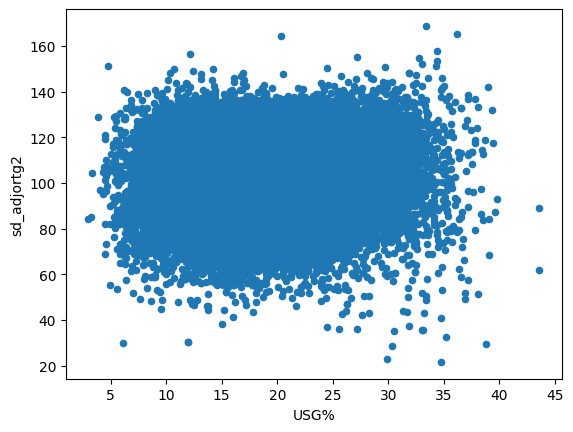

In [32]:
cbb_kp[cbb_kp['MP']>=100].plot.scatter(x='USG%',y='sd_adjortg2')
plt.show()

You can see that this looks better but it still bends up a little for low USG%. The low-usage penalty below will try to pull those down a little in the final adjustment.

To implement the strength-of scheule weight I need the average team efficiency for each season. This is stored in the dictionary below. The avgPPGdict below is the dictionary of average points per game for each season in college basketball. This is needed in the Win Shares formula used below.

Note: Strength of schedule adjustment is just the average points per 100 possessions in college basketball divided by a team's opponents average points allowed per 100 possessions. You get multiplied by a factor greater than 1 if you played teams who on average allowed less than the average points. 

In [33]:
adjOdict=dict(
sn2011=103.23,
sn2012=102.81,
sn2013=102.38,
sn2014=105.0,
sn2015=104.16,
sn2016=104.72,
sn2017=104.51,
sn2018=104.82,
sn2019=104.09,
sn2020=102.13,
sn2021=102.35,
sn2022=102.77,
sn2023=104.89,
sn2024=105.99,
sn2025=106.60
)    

avgPPGdict=dict(
sn2011=68.4,
sn2012=67.4,
sn2013=66.9,
sn2014=70.2,
sn2015=66.9,
sn2016=72.3,
sn2017=72.7,
sn2018=73.6,
sn2019=71.9,
sn2020=70.2,
sn2021=70.8,
sn2022=70.1,
sn2023=70.7,
sn2024=72.6,
sn2025=72.8)    

In [34]:
def sos(row):
    season = 'sn'+str(row['Season'])
    return adjOdict[season]/row['AdjOppDE']

In [35]:
cbb_kp['sos_factor']=cbb_kp.apply(sos,axis=1)

Add a small adjustment to defensive Win Shares using a similar strength of schedule adjustment as above.

In [36]:
def adjustDWS(row):
    return row['DWS']*row['AdjOppOE']/103

In [37]:
cbb_kp['vDWS']=cbb_kp.apply(adjustDWS,axis=1)

Add in a low-USG% penalty and SOS weight. 

**This is final adjORtg which is the key ingredient in the WS formula.**

In [38]:
def adjust2(row):
    season = 'sn'+str(row['Season'])
    if (row['USG%']<19):
        return (row['sd_adjortg2']+1.5*(row['USG%']-19))*(adjOdict[season])/row['AdjOppDE']        
    else:
        return row['sd_adjortg2']*(adjOdict[season])/row['AdjOppDE']


In [39]:
cbb_kp['adjusted_ORtg']=cbb_kp.apply(adjust2,axis=1)

Let's check adjORtg compared to both ORtg and USG%.

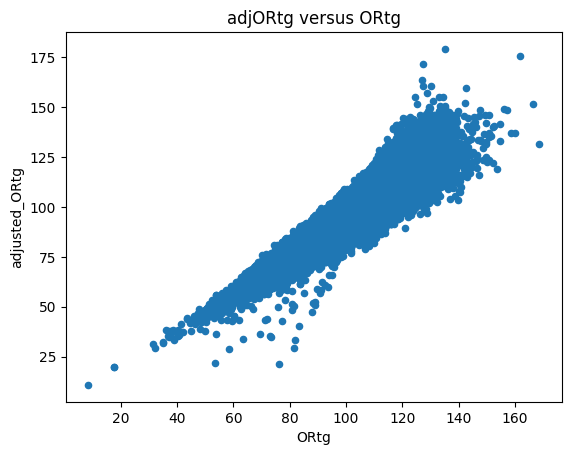

In [40]:
cbb_kp[cbb_kp['MP']>=100].plot.scatter(x='ORtg',y='adjusted_ORtg')
plt.title('adjORtg versus ORtg')
plt.show()

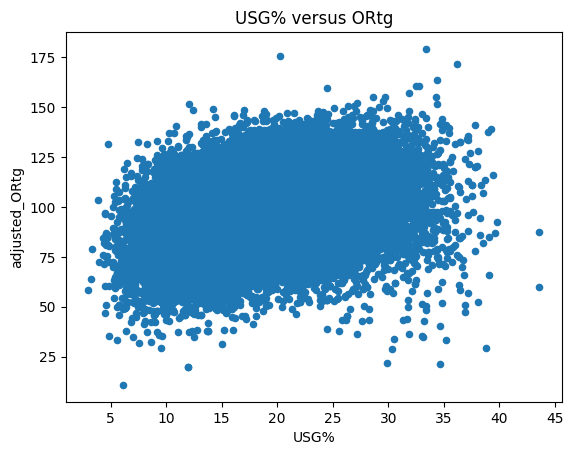

In [41]:
cbb_kp[cbb_kp['MP']>=100].plot.scatter(x='USG%',y='adjusted_ORtg')
plt.title('USG% versus ORtg')
plt.show()

Note that 

1. The cone shape is gone.
2. The variance is more constant.
3. The upward trend is preserved.

Finally define vOWS following the OWS formula but using adjORtg as input. (See https://www.sports-reference.com/cbb/about/ws.html for details on the Win Shares formula.)

In [42]:
def vOWS(row):
    season = 'sn'+str(row['Season'])
    return (((row['adjusted_ORtg']/100)-.875*1.03)*row['IndOffPoss'])/((.5*avgPPGdict[season])*row['AdjTempo']/66.8)

In [43]:
cbb_kp['vOWS']=cbb_kp.apply(vOWS,axis=1)

In [44]:
cbb_kp['vWS']=cbb_kp['vOWS']+cbb_kp['vDWS']

Check vWS versus traditional WS.

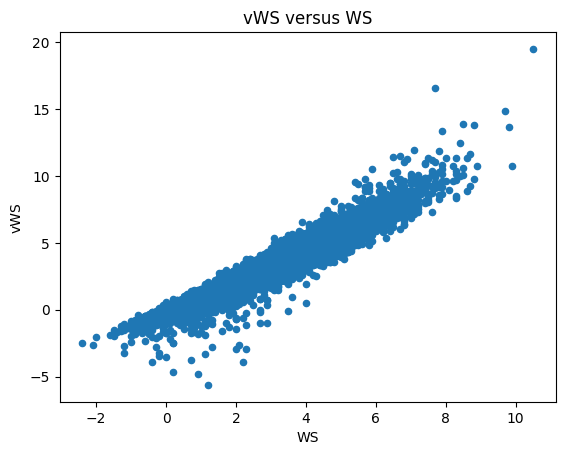

In [45]:
cbb_kp[cbb_kp['MP']>=100].plot.scatter(x='WS',y='vWS')
plt.title('vWS versus WS')
plt.show()

They are very correlated which makes sense but there are some changes.

# Did it work?

Ken Pomeroy's Adjusted Efficiency Margin (adjEM) is the standard metric to evaluate team quality. Every team uses it and it's part of the NCAA Tournament evaluation process. Let's check correlation between adjEM and traditional WS and vWS summed over each team.

In [46]:
vws_test=cbb_kp[cbb_kp['MP']>=100][['WS','vWS','Team','Season']].groupby(['Team','Season'],as_index=0).sum()
adjem=cbb_kp[['Team','Season','AdjEM']].groupby(['Team','Season'],as_index=0).mean()

In [47]:
vws_test2=vws_test.merge(adjem,how='left',on=['Team','Season'])

In [48]:
vws_test2[['WS','vWS','AdjEM']].corr().round(4)

,WS,vWS,AdjEM
WS,1.0000,0.9531,0.7757
vWS,0.9531,1.0000,0.8748
AdjEM,0.7757,0.8748,1.0000


# Conclusion

**Yes!** *There's a significant jump in correlation between Team Quality (AdjEM) and my vWS compared to traditional WS.*

vWS also looks good in that several of the all time college greats are at the top of the list:

In [49]:
cbb_kp[cbb_kp['MP']>=100][['Player','Team','W-L','Season','MP','USG%','vWS','WS']].sort_values(by='vWS',ascending=0)[0:25]

,Player,Team,W-L,Season,MP,USG%,vWS,WS
826,Zach Edey,purdue,34-5,2024,1248.0,33.4,19.495031,10.5
43726,Doug McDermott,creighton,27-8,2014,1181.0,36.2,16.558108,7.7
56342,Kemba Walker,connecticut,32-9,2011,1543.0,32.4,14.879473,9.7
62575,Jimmer Fredette,brigham-young,32-5,2011,1323.0,37.8,13.868230,8.5
13094,Zach Edey,purdue,29-6,2023,1077.0,32.8,13.807333,8.8
14548,Frank Kaminsky,wisconsin,36-4,2015,1311.0,28.6,13.628445,9.8
54382,Doug McDermott,creighton,28-8,2013,1138.0,34.3,13.370607,7.9
32944,Cooper Flagg,duke,35-3,2025,1135.0,30.9,12.474454,8.4
66863,Reggie Hamilton,oakland,20-16,2012,1284.0,34.8,11.967586,7.1
71510,Aniwaniwa Tait-Jones,california-san-diego,17-15,2025,1042.0,29.5,11.880377,7.8


In [50]:
#cbb_kp.to_csv('cbb_kp_with_vWS_October.csv',index=0)

Final Note: Recall that WS had the interpretation of adding up (over players) to about the number of team wins. That is still basically true. Mean absolute error over all teams is 2.0 for WS, and for vWS is 3.0.  